# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim_data_prep.ipynb`


## Organization of the Notebook

- Set up database of data sets
- Application of different pre-treatments (including BinSim) to each data set
- Create persistance storage of data
- Analyse dataset characteristics


#### Needed Imports

In [1]:
import itertools
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: name of the data set (see below the list of data sets)
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix, the original data before any pre-treatments
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `Ionly`: missing value imputation by 1/2 min, only
    - `P`: Pareto scaled data, after missing value imputation
    - `NP`: Missing value imputed, Pareto scaled and normalized
    - `NGP`: Missing value imputed, normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD 2/15)
- YD2 (YD 6/15)
- vitis_types (GD types)

### Description of grapevine data sets

Grapevine Datasets (Negative and Positive) - 33 samples belonging to 11 different grapevine varieties (3 samples per variety/biological group) of FT-ICR-MS metabolomics data obtained in negative and positive ionization mode.

5 different _Vitis_ species (other than _V. vinifera_) varieties:

- CAN - 3 Samples (14, 15, 16) of _V. candicans Engelmann_ (VIVC variety number: 13508)
- RIP - 3 Samples (17, 18, 19) of _V. riparia Michaux_ (Riparia Gloire de Montpellier, VIVC variety number: 4824) 
- ROT - 3 Samples (20, 21, 22) of _V. rotundifolia_ (Muscadinia Rotundifolia Michaux cv. Rotundifolia, VIVC variety number: 13586)
- RU - 3 Samples (35, 36, 37) of _V. rupestris Scheele_ (Rupestris du lot, VIVC variety number: 10389)
- LAB - 3 Samples (8, 9, 10) of _V. labrusca_ (Isabella, VIVC variety number: 5560)

6 different _V. vinifera_ cultivars varieties are:

- SYL - 3 samples (11, 12, 13) of the subspecies _sylvestris_ (VIVC variety number: -)
- CS - 3 Samples (29, 30, 31) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 1929)
- PN - 3 Samples (23, 24, 25) of the subspecies _sativa_ cultivar Pinot Noir (VIVC variety number: 9279)
- REG - 3 Samples (38, 39, 40) of the subspecies _sativa_ cultivar Regent (VIVC variety number: 4572)
- RL - 3 Samples (26, 27, 28) of the subspecies _sativa_ cultivar Riesling Weiss (VIVC variety number: 10077)
- TRI - 3 Samples (32, 33, 34) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 15685)

Data acquired by Maia et al. (2020):

- Maia M, Ferreira AEN, Nascimento R, et al. Integrating metabolomics and targeted gene expression to uncover potential biomarkers of fungal / oomycetes ‑ associated disease susceptibility in grapevine. Sci Rep. Published online 2020:1-15. doi:10.1038/s41598-020-72781-2
- Maia M, Figueiredo A, Silva MS, Ferreira A. Grapevine untargeted metabolomics to uncover potential biomarkers of fungal/oomycetes-associated diseases. 2020. doi:10.6084/m9.figshare.12357314.v1

**Peak Alignment** and **Peak Filtering** were performed with function `metabolinks.peak_alignment.align()`. Human leucine enkephalin (Sigma Aldrich) was used as the reference feature (internal standard, [M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da).

**4** data matrices were constructed from this data:

- Data sets named `GD_pos_global2` (GDg2+) and `GD_neg_global2` (GDg2-) were generated after retaining only features that occur (globally) at least twice in all 33 samples of the data sets (filtering/alignment) for the **positive mode** data acquisition and the **negative mode** data acquisition, respectively.
- Data sets named `GD_pos_class2` (GDc2+) and `GD_neg_class2` (GDc2-) were generated after retaining only features that occur at least twice in the three replicates of at least one _Vitis_ variety in the data sets (filtering/alignment) for the **positive mode** data acquisition and the **negative mode** data acquisition, respectively.

For the purpose of assessing the performance of supervised methods each of these four datasets was used with target labels defining classes corresponding to replicates of each of the 11 Vitis species/cultivars.

For the purpose of assessing the performance of supervised methods under a binary (two-class) problem, data set `GD_neg_class2` was also used with target labels defining two classes: Vitis vinifera cultivars and "wild", non-vinifera Vitis species. This is dataset `vitis_types` (GD types).

### Description of the yeast data set

Yeast dataset - 15 samples belonging to 5 different yeast strains of _Saccharomyces cerevisiae_ (3 biological replicates per strain/biological group) of FT-ICR-MS metabolomics data obtained in positive ionization mode. The 5 strains were: the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1 (GLO1), ΔGLO2 (GLO2), ΔGRE3 (GRE3) and ΔENO1 (ENO1). These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Data acquired by Luz et al. (2021):

- Luz J, Pendão AS, Silva MS, Cordeiro C. FT-ICR-MS based untargeted metabolomics for the discrimination of yeast mutants. 2021. doi:10.6084/m9.figshare.15173559.v1

**Peak Alignment** and **Peak Filtering** was performed with MetaboScape 4.0 software (see reference above for details in sample preparation, pre-processing, formula assignment). In short, Yeast Dataset was obtained with Electrospray Ionization in Positive Mode and pre-processed by MetaboScape 4.0 (Bruker Daltonics). Human leucine enkephalin (Sigma Aldrich) was used as the reference feature (internal standard, [M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da).

**2** data matrices were constructed from this data:

- Data set named `YD` (YD 2/15) was generated after retaining only features that occur (globally) at least twice in all 15 samples (filtering/alignment).
- Data set named `YD2` (YD 6/15) was generated after retaining only features that occur (globally) at least six times in all 15 samples (filtering/alignment).

For the purpose of assessing the performance of supervised methods, this data set was used with target labels defining classes corresponding to replicates of each of the 4 yeast strains.

#### Loading yeast data set

In [3]:
def read_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    peak_cols = ['m/z', 'Name', 'Formula']
    intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    peaks = data[peak_cols]
    intensities = data[intensity_cols]

    # replace zeros for NaN's
    intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        intensities = mtl.add_labels(intensities, labels=add_labels)
    
    return {'filename': filename,
            'peaks':peaks,
            'intensities': intensities}

def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

In [4]:
# Labels of the 5 biological groups (5 yeast strains) - only added after
yeast_classes = 'WT ΔGRE3 ΔENO1 ΔGLO1 ΔGLO2'.split()

In [5]:
# Read in the file and keep results in dicts 

prefix_to_drop = None # change to 'ENO' to remove ENO strain

# MScape non-normalized dataset
MS_data = read_MetScape_file('5yeasts_notnorm.csv', 
                             remove_ref_feat=None,
                             add_labels=None,
                             col_renamer=renamer)

#MS_data

In [6]:
# keep features that appear in at least two samples
yeast_datamatrix = transf.keep_atleast(MS_data['intensities'].transpose(), minimum=2)
yeast_datamatrix

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,557228.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,NaN,NaN,NaN,NaN,548196.50,NaN,NaN,NaN,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,540980.9375,NaN,543241.1875,NaN,NaN,NaN,551425.1250,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,562062.625,NaN,NaN,NaN,549861.4375,NaN,553295.750,545085.3750
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,NaN,NaN,540392.625,NaN,550756.625,NaN,NaN,NaN,NaN,545906.1875
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,NaN,NaN,NaN,558994.1250,548675.125,NaN,NaN,NaN,NaN,NaN


### Building data-sets data base

In [7]:
datasets = {}
# From the alignments_new store

# GD_neg_global2 (GDg2-)
data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg').transpose()
gd_labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '-',
                              'name': 'GDg2-',
                              'data': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

# GD_pos_global2 (GDg2+)
data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '+',
                              'name': 'GDg2+',
                              'data': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

# GD_neg_class2 (GDc2-)
data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '-',
                              'name': 'GDc2-',
                              'data': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

# GD_pos_class2 (GDc2+)
data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '+',
                              'name': 'GDc2+',
                              'data': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

# YD (YD 2/15)
yeast_labels = [item for item in yeast_classes for i in range(3)]

datasets['YD'] = {'source': 'yeast',
                            'alignment': '1-2',
                            'mode': '+',
                            'name': 'YD 2/15',
                            'data': yeast_datamatrix,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

# YD (YD 6/15)
min_non_na = '6/15'

yeast_datamatrix_less_na = transf.keep_atleast(yeast_datamatrix, minimum=eval(min_non_na))

datasets['YD2'] = {'source': 'yeast',
                            f'alignment': 'at_least {min_non_na}',
                            'mode': '+',
                            'name': 'YD ' + min_non_na,
                            'data': yeast_datamatrix_less_na,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

# vitis_types (GD types)
vitis_types = {'CAN': 'wild', 'RIP': 'wild', 'ROT': 'wild','RU': 'wild', 'LAB': 'wild',
               'SYL': 'wild','REG': 'vinifera','CS': 'vinifera','PN': 'vinifera','RL': 'vinifera',
               'TRI': 'vinifera'}

gd_type_labels = [vitis_types[lbl] for lbl in gd_labels]

datasets['vitis_types'] = {'source': 'grapevine',
                            'alignment': '2-1',
                            'mode': '-',
                            'name': 'GD types',
                            'data': datasets['GD_neg_class2']['data'],
                            'target': gd_type_labels,
                            'classes': list(pd.unique(gd_type_labels))}

print('target for grapevine 11-variety data sets')
print(datasets['GD_neg_global2']['target'])
print('------\ntarget for 4 yeast strains data set')
print(datasets['YD']['target'])
print('------\ntarget for 2-class wild Vitis vs Vitis vinifera data set')
print(datasets['vitis_types']['target'])

target for grapevine 11-variety data sets
['CAN', 'CAN', 'CAN', 'CS', 'CS', 'CS', 'LAB', 'LAB', 'LAB', 'PN', 'PN', 'PN', 'REG', 'REG', 'REG', 'RIP', 'RIP', 'RIP', 'RL', 'RL', 'RL', 'ROT', 'ROT', 'ROT', 'RU', 'RU', 'RU', 'SYL', 'SYL', 'SYL', 'TRI', 'TRI', 'TRI']
------
target for 4 yeast strains data set
['WT', 'WT', 'WT', 'ΔGRE3', 'ΔGRE3', 'ΔGRE3', 'ΔENO1', 'ΔENO1', 'ΔENO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO2', 'ΔGLO2', 'ΔGLO2']
------
target for 2-class wild Vitis vs Vitis vinifera data set
['wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera']


In [8]:
# Example
datasets['YD2']['data']

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,229.2123516866 Da,394.1157975983 Da,379.1049581299 Da,248.0382813898 Da,355.6157973903 Da,234.1618657562 Da,384.2188536141 Da,561.1740363894 Da,384.1550071491 Da,486.1583934820 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,772182.5000,NaN,594449.9375,698648.0000,NaN,NaN,704317.1875,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,NaN,601594.2500,616405.1875,573408.3125,NaN,NaN,591270.6875,594117.8125,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,748387.5625,661618.0625,NaN,NaN,577509.4375,628977.9375,NaN,NaN,592246.8125
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,670217.1250,NaN,582062.5000,NaN,NaN,NaN,NaN,561696.1875,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,883340.5000,NaN,NaN,NaN,NaN,601161.2500,559238.4375
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,562025.3125,NaN,NaN,556031.8125,NaN,NaN,NaN,NaN,681038.2500,558403.9375
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580237.7500,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,NaN,NaN,NaN,657626.3125,NaN,NaN,NaN,NaN
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,597902.5000,NaN,594469.9375,NaN,NaN,NaN,664188.5000,597523.3125,NaN,NaN
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,664256.5000,NaN,NaN,618080.8125,540651.7500,607250.8125,590962.6250,569196.3750,NaN,704541.7500


### Colors for plots to ensure consistency

#### 11 variety grapevine data sets

In [9]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

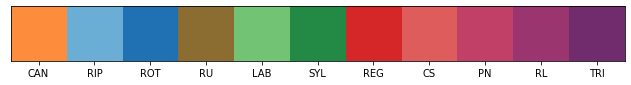

In [10]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [11]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]
datasets['YD2']['label_colors'] = yeast_label_colors
datasets['YD2']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD2']['target']]

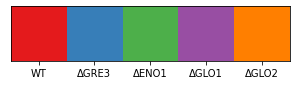

In [12]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types (wild and _vinifera_)

In [13]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

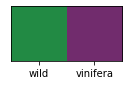

In [14]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

Samples and respective target labels of each dataset

In [15]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [16]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [17]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [18]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


## Setup of Random Forest missing-value imputation

In [48]:
rf_estimator = ExtraTreesRegressor(n_estimators=10)
imputer = IterativeImputer(random_state=0, estimator=rf_estimator,
                           n_nearest_features=100, min_value=0.0,
                           verbose=2)

In [49]:
sample_data = datasets["YD"]["data"]

sample_data

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,557228.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,NaN,NaN,NaN,NaN,548196.50,NaN,NaN,NaN,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,540980.9375,NaN,543241.1875,NaN,NaN,NaN,551425.1250,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,562062.625,NaN,NaN,NaN,549861.4375,NaN,553295.750,545085.3750
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,NaN,NaN,540392.625,NaN,550756.625,NaN,NaN,NaN,NaN,545906.1875
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,NaN,NaN,NaN,558994.1250,548675.125,NaN,NaN,NaN,NaN,NaN


In [50]:
start = perf_counter()
print('Starting imputation')

imputed_data = imputer.fit_transform(sample_data)

end = perf_counter()
print(f'Done! took {(end - start):.3f} s')

imputed_data = pd.DataFrame(imputed_data, index=sample_data.index, columns=sample_data.columns)
imputed_data

Starting imputation
[IterativeImputer] Completing matrix with shape (15, 1973)
[IterativeImputer] Ending imputation round 1/10, elapsed time 13.87
[IterativeImputer] Change: 62363954.12284227, scaled tolerance: 421969.44 
[IterativeImputer] Ending imputation round 2/10, elapsed time 27.65
[IterativeImputer] Change: 49663891.4875, scaled tolerance: 421969.44 
[IterativeImputer] Ending imputation round 3/10, elapsed time 41.80
[IterativeImputer] Change: 52015933.43125, scaled tolerance: 421969.44 
[IterativeImputer] Ending imputation round 4/10, elapsed time 55.70
[IterativeImputer] Change: 47219375.84375, scaled tolerance: 421969.44 
[IterativeImputer] Ending imputation round 5/10, elapsed time 69.75
[IterativeImputer] Change: 49367360.4, scaled tolerance: 421969.44 
[IterativeImputer] Ending imputation round 6/10, elapsed time 83.47
[IterativeImputer] Change: 49945127.175, scaled tolerance: 421969.44 
[IterativeImputer] Ending imputation round 7/10, elapsed time 97.18
[IterativeImputer

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,557228.37500,554529.6875,557728.625,552692.95000,549507.725,548208.950,547813.7875,546919.84375,547883.6000,545495.78125
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,557228.37500,554529.6875,557728.625,549542.36250,549507.725,548208.950,548155.0625,546018.78750,546530.5625,545495.78125
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,555365.53750,556787.8125,555561.625,551117.65625,549299.575,548208.950,548155.0625,546018.78750,547883.6000,545495.78125
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,554434.11875,554529.6875,555561.625,549542.36250,549507.725,548196.500,548155.0625,546919.84375,547883.6000,545413.70000
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,552571.28125,554529.6875,555561.625,551117.65625,549507.725,548208.950,548496.3375,546018.78750,547883.6000,545413.70000
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,554434.11875,556787.8125,557728.625,549542.36250,549715.875,548208.950,548496.3375,546018.78750,547883.6000,545495.78125
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,555365.53750,540980.9375,553394.625,543241.18750,549924.025,548208.950,547813.7875,551425.12500,549236.6375,545495.78125
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,555365.53750,554529.6875,562062.625,546391.77500,550132.175,548208.950,549861.4375,548721.95625,553295.7500,545085.37500
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,553502.70000,554529.6875,540392.625,546391.77500,550756.625,548215.175,548837.6125,548721.95625,550589.6750,545906.18750
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,552571.28125,556787.8125,557728.625,558994.12500,548675.125,548202.725,547472.5125,547820.90000,549236.6375,545495.78125


In [61]:
def impute_RF(df, nearest_features=100, n_trees=10):
    rf_estimator = ExtraTreesRegressor(n_estimators=n_trees)
    imputer = IterativeImputer(random_state=0, estimator=rf_estimator,
                           n_nearest_features=nearest_features, min_value=0.0,
                           verbose=0)
    imputed_data = imputer.fit_transform(df)
    return pd.DataFrame(imputed_data, index=df.index, columns=df.columns)
    

## Data transformations and pre-treatments

Each data set is transformed by Binary simplification and treated by three combinations of more established treatments (generating 4 data sets with different treatments applied).

### Traditional and more established  intensity-based Pre-Treatments

Missing value imputation is mandatory for the data sets since many statistical methods performed downstream can't handle missing values. Missing value imputation procedure was applied before any treatment: missing values were replaced with half of the minimum intensity value present in the whole data matrix - Limit of Detection type of imputation commonly applied in metabolomics data analysis. This was performed with the `fillna_frac_min`function from metabolinks.

#### Combinations of intensity-based pre-treatments made:

- Ionly Treatment - Only Missing Value Imputation.

- **P Treatment** - Missing Value Imputation and Pareto Scaling.

- **NP Treatment** - Missing Value Imputation, Normalization by reference feature (Leucine Enkephalin) and Pareto Scaling.

- **NGP Treatment** - Missing Value Imputation, Normalization by reference feature (Leucine Enkephalin), Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak (reference feature) is removed upon normalization. Order of pre-treatments is the order in which they were mentioned.

### Binary Simplification (BinSim)

- **BinSim Treatment** - `df_to_bool` function

In [62]:
# Represents Binary Simplification pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

# Performs all pre-treatment combinations mentioned
def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data']
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Imputation by RF
    imputedRF = impute_RF(data, nearest_features=100, n_trees=10)
    
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Normalization by a reference feature RF
    if norm_ref is not None:
        normRF = transf.normalize_ref_feature(imputedRF, norm_ref, remove=True)
    else:
        normRF = imputedRF
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))

    # Pareto Scaling and Generalized Logarithmic Transformation
    P_RF = transf.pareto_scale(imputedRF)
    NP_RF = transf.pareto_scale(normRF)
    NGP_RF = transf.pareto_scale(transf.glog(normRF, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP
    
    dataset['Ionly_RF'] = imputedRF
    dataset['P_RF'] = P_RF
    dataset['NP_RF'] = NP_RF
    dataset['NGP_RF'] = NGP_RF    

Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard, [M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da) used for these datasets.

Search in the grapevine data sets for the reference feature and confirm the reference feature in the yeast data sets with `find_closest_features` from metabolinks package.

In [63]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
# Theoretical mass for positive mode Leucine Enkephalin - 556.276575
Leu_Enk_neg = 554.262022
Leu_Enk_pos = 556.276575

# Reference Feature in the yeast dataset
leu_enk_name = '555.2692975341 Da'

In [64]:
query_datasets = [name for name in datasets if datasets[name]['source']=='grapevine']

for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...')
    ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable)
        delta = closest[ref_variable] - ref_variable
        print(f'In data: {closest[ref_variable]} delta = {delta:.3e}\n')

query_datasets = [name for name in datasets if name.startswith('YD')]

ref_variable = leu_enk_name
for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...') 
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable, '\n')
    else:
        print('Ref feature not found\n')

looking for reference in GD_neg_global2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_global2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in GD_neg_class2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_class2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in vitis_types ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in YD ...
Found ref feature 555.2692975341 Da 

looking for reference in YD2 ...
Found ref feature 555.2692975341 Da 



##### Apply the different pre-treatments and get the results in their respective dictionaries

In [65]:
for name, ds in datasets.items():
    dataset_name = datasets[name]["name"]
    print(f'Applying pre-processing transformations to data in {dataset_name}', end=' ...')
    start = perf_counter()
    
    if name.startswith('YD'):
        ref_variable = leu_enk_name
    else:
        ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    
    compute_transf(ds, norm_ref=ref_variable)
    
    end = perf_counter()

    print(f'done! took {(end - start):.3f} s')

Applying pre-processing transformations to data in GDg2- ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 260.192 s
Applying pre-processing transformations to data in GDg2+ ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 512.410 s
Applying pre-processing transformations to data in GDc2- ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 215.487 s
Applying pre-processing transformations to data in GDc2+ ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 331.200 s
Applying pre-processing transformations to data in YD 2/15 ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 136.538 s
Applying pre-processing transformations to data in YD 6/15 ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 44.233 s
Applying pre-processing transformations to data in GD types ...

C:\Users\a3nf\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


done! took 217.991 s


<span style="color:darkred;">------- Checkpoint for API migration</span>

In [66]:
# uncomment to generate checkpoint for old API
#treat_neg2['NGP'].to_csv('treat_neg2_NGP.csv', sep='\t')

roundrobin = pd.read_csv('treat_neg2_NGP.csv', sep='\t', header=[0,1], index_col=0)

# should not raise AssertionError:
assert_frame_equal(roundrobin, datasets['GD_neg_class2']['NGP'].transpose())


# A NOTE on pandas problem:
# assert_frame_equal(roundrobin.transpose(), treat_neg2['NGP'])
# fails the assertion because of m/z value float innacuracy when save to csv.

#roundrobin.transpose()

<span style="color:darkred;">------- END checkpoint for API migration</span>

### Generate json files

In [67]:
# ensure dir exists
path = Path.cwd() / "paperimages"
path.mkdir(parents=True, exist_ok=True)

storepath = Path.cwd() / "paperimages" / 'processed_data.h5'

store = pd.HDFStore(storepath, complevel=9, complib="blosc:blosclz")
#pd.set_option('io.hdf.default_format','table')

# keep json serializable values and store dataFrames in HDF store

serializable = {}

for dskey, dataset in datasets.items():
    serializable[dskey] = {}
    for key, value in dataset.items():
        #print(dskey, key)
        if isinstance(value, pd.DataFrame):
            storekey = dskey + '_' + key
            #print('-----', storekey)
            store[storekey] = value
            serializable[dskey][key] = f"INSTORE_{storekey}"
        else:
            serializable[dskey][key] = value
store.close()
            

path = path / 'processed_data.json'
with open(path, "w", encoding='utf8') as write_file:
    json.dump(serializable, write_file)

#serializable

### Check data persistence, by reading it back

In [68]:
old_datasets = datasets

path = Path.cwd() / "paperimages" / 'processed_data.json'
storepath = Path.cwd() / "paperimages" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
            # transform colors, saved as lists in json, back into tuples
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
#datasets

In [69]:
roundrobin = pd.read_csv('treat_neg2_NGP.csv', sep='\t', header=[0,1], index_col=0)

# should not raise AssertionError:
assert_frame_equal(roundrobin, datasets['GD_neg_class2']['NGP'].transpose())

# check all dataframes in datasets and rr_datasets
for dskey, dataset in datasets.items():
    for key, value in dataset.items():
        if isinstance(value, pd.DataFrame):
            assert_frame_equal(value, old_datasets[dskey][key])

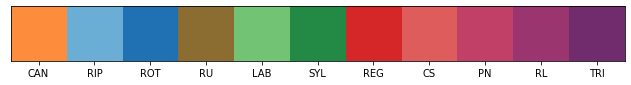

In [70]:
label_colors = datasets['GD_neg_class2']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

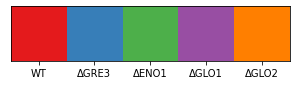

In [71]:
label_colors = datasets['YD']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

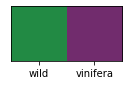

In [72]:
label_colors = datasets['vitis_types']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

In [73]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [74]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


In [75]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


### Dataset Characteristics

Building a table with general characteristics about the 7 data sets studied.

In [76]:
def characterize_dataset(dskey, ds):
    "Computes and returns some general characteristics of a dataset in a dictionary."

    dataset_chrs = {}
    
    name = ds['name'] # Name of the dataset
    n_samples, n_feats = ds['data'].shape
    n_classes = len(ds['classes'])
       
    Feat_Sample = ds['data'].count(axis=1) # Nº Features in each sample
    Min_Feat_Sample = str(Feat_Sample.min()) # Minimum nº Features in a sample
    Max_Feat_Sample = str(Feat_Sample.max()) # Maximum nº Features in a sample
    Average_Feat_Sample = Feat_Sample.mean() # Average nº Features in a sample
    
    avg_feat_per_sample = int(round(Average_Feat_Sample,0)) # Round
    
    Samp_Class = len(ds['target'])/len(ds['classes']) # Nº Sample per Class
    if dskey == 'vitis_types':
        Samp_Class = '15 Vitis vinifera, 18 Wild'
        #Samp_Class = '15 $\it{Vitis}$ $\it{Vinifera}$, 18 Wild'
    else:
        Samp_Class = str(int(Samp_Class))
    
    n_na = ds['data'].isna().sum().sum() # Nº of missing values in the dataset
    
    p_na = round(100.0 * n_na / (n_samples * n_feats), 2) # % of missing values in the dataset
    
    avg_na_per_feature = (n_samples - ds['data'].count(axis=0)).mean()
    avg_na_per_feature = int(round(avg_na_per_feature, 0))
    
    return {'Data set': name,
            '# samples': n_samples,
            '# features': n_feats,
            'features / sample (range)': f'{avg_feat_per_sample} ({Min_Feat_Sample}-{Max_Feat_Sample})',
            '# classes': n_classes,
            'samples / class':Samp_Class,
            '% missing values': p_na,} 
            #'missing values / feature': avg_na_per_feature}

data_characteristics = [characterize_dataset(dskey, ds) for dskey, ds in datasets.items()]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Data set')
data_characteristics

,# samples,# features,features / sample (range),# classes,samples / class,% missing values
Data set,,,,,,
GDg2-,33,3629,658 (367-1002),11,3,81.86
GDg2+,33,7026,1164 (355-2141),11,3,83.43
GDc2-,33,3026,547 (338-919),11,3,81.91
GDc2+,33,4565,824 (215-1670),11,3,81.94
YD 2/15,15,1973,685 (584-757),5,3,65.27
YD 6/15,15,606,468 (383-514),5,3,22.76
GD types,33,3026,547 (338-919),2,"15 Vitis vinifera, 18 Wild",81.91


In [77]:
data_characteristics.to_excel('paperimages/dataset_characteristics.xlsx', index=True)

### PCA scores plots for the 7 data sets

Representation of the samples when projected in the 2 Principal Components obtained from PCA.

Preliminary assessment of the extent of class’s proximity, and consequent degree of difficulty for clustering and classification methods. Greater proximity/overlap would mean a more difficult task for the methods since it would mean the classes are similar to each other or less well defined.

Ellipses shown are 95% confidence ellipses for each class.

In [78]:
# To consider: Maybe remove this function? No longer used
def plot_PCA_old(principaldf, label_colors, label_symbols=None, components=(1,2), var_explained=None, title="PCA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #with sns.axes_style("whitegrid"):
    ax.axis('equal')
    if var_explained is not None:
        v1, v2 = var_explained[loc_c1], var_explained[loc_c2]
        ax.set_xlabel(f'{col_c1_name} ({100*v1:.1f}%)', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name} ({100*v2:.1f}%)', fontsize = 15)
    else:
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

    unique_labels = principaldf['Label'].unique()
    if label_symbols is None:
        label_symbols = {lbl: 'o' for lbl in unique_labels}

    lbl_handles = {}
    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        hndl = ax.scatter(subset[col_c1_name], subset[col_c2_name],
                          lw=1,ec='black', alpha=0.8,
                          marker=label_symbols[lbl], 
                          s=80, color=label_colors[lbl], label=lbl)
        lbl_handles[lbl] = hndl

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)
    return lbl_handles

def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


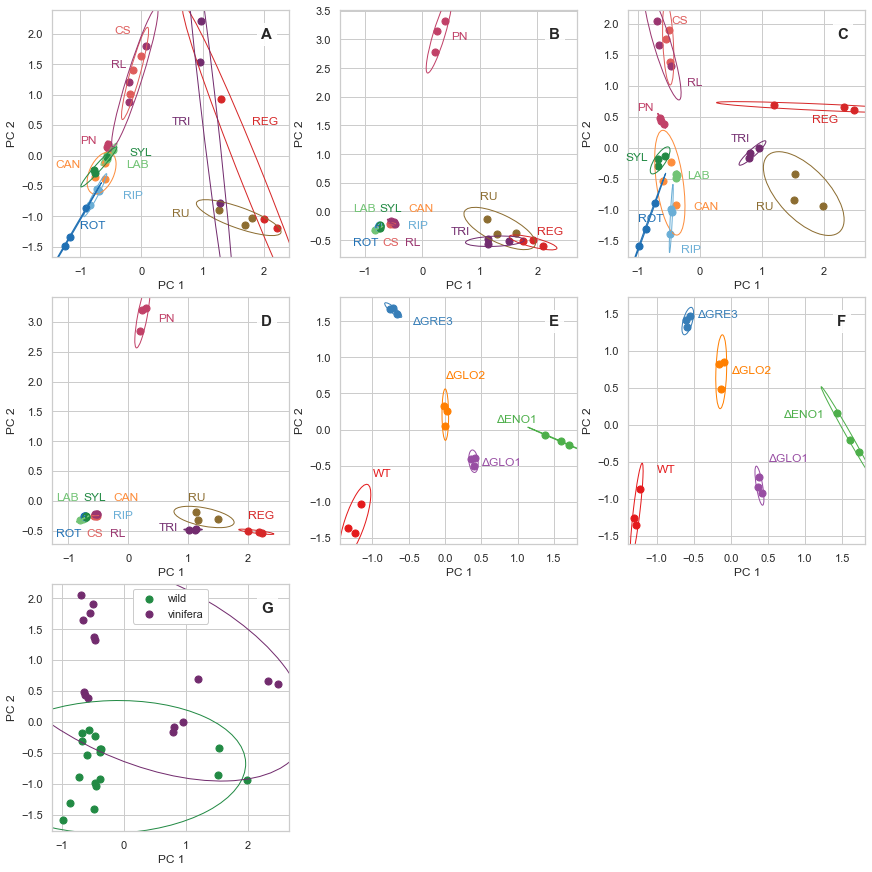

In [79]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)

        for (dskey, ds), ax in zip(datasets.items(), axs.ravel()):
            df = datasets[dskey]['Ionly']
            tf = transf.FeatureScaler(method='standard')
            df = tf.fit_transform(df)
            #print(df)
            ax.axis('equal')
            principaldf = ma.compute_df_with_PCs(df, n_components=5, whiten=True, labels=datasets[dskey]['target'], return_var_ratios=False)

            lcolors = datasets[dskey]['label_colors']
            #plot_PCA(principaldf, lcolors, components=(1,2), title=datasets[dskey]['name'], ax=ax)
            plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)

        axs[2][1].remove()
        axs[2][2].remove()
        #axs[0][1].legend(loc='upper right', ncol=1)
        #axs[1][1].legend(loc='upper right', ncol=1)
        axs[2][0].legend(loc='upper center', ncol=1, framealpha=1)
        locs_YD = {'WT':(-1,-0.65),
                   'ΔGRE3':(-0.45, 1.45),
                   'ΔENO1':(0.7, 0.1),
                   'ΔGLO1':(0.5, -0.5),
                   'ΔGLO2':(0,0.7) }
        for lbl in datasets['YD']['classes']:
            axs[1][1].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])
        for lbl in datasets['YD']['classes']:
            axs[1][2].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])

        locs_GD = {'CAN':(-1.4,-0.2),
                       'CS':(-0.45, 2),
                       'LAB':(-0.25, -0.2),
                       'PN':(-1, 0.2),
                       'REG':(1.8,0.5),
                       'RIP':(-0.3,-0.7),
                       'RL':(-0.5, 1.45),
                       'ROT':(-1, -1.2),
                       'RU':(0.5, -1),
                       'SYL':(-0.2,0),
                       'TRI':(0.5,0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.1,-1),
                       'CS':(-0.45, 2),
                       'LAB':(-0.2, -0.5),
                       'PN':(-1, 0.6),
                       'REG':(1.8,0.4),
                       'RIP':(-0.3,-1.7),
                       'RL':(-0.2, 1),
                       'ROT':(-1, -1.2),
                       'RU':(0.9, -1),
                       'SYL':(-1.2,-0.2),
                       'TRI':(0.5,0.1),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][2].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.3),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[1][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.4),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0.2),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.4),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][1].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()[0:7]):
            ax.text(0.88, 0.9, letter, ha='left', va='center', fontsize=15, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.9))
        
        plt.show()
        f.savefig('paperimages/PCAs.pdf', dpi=200)
        f.savefig('paperimages/PCAs.png', dpi=600)


### Graphical Representation of a portion of the GDc2- dataset after BinSim or NGP pre-treatments

Portion represented: From feature 51 to 150 from the GDc2- dataset.

In [80]:
# Needed extra import
from matplotlib import cm

# For the BinSim legend
Reds = cm.get_cmap('Reds', 20)
Present_Feature = mpatches.Patch(color=Reds(range(20))[-1], label='Present Feature (1)')
Absent_Feature = mpatches.Patch(color='white', label='Absent Feature (0)')

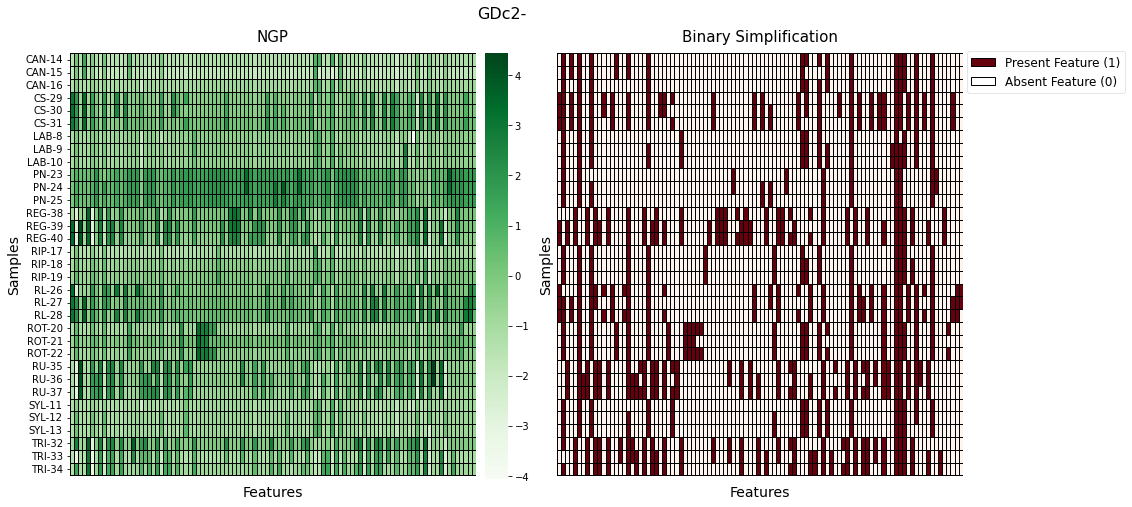

In [81]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(16,8))

cbar_ax = fig.add_axes([0.485, .13, .02, .74]) # For the colorbar

# NGP Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['NGP'].iloc[:,50:150], annot=False, ax=axl, cmap = 'Greens', linewidths = 1, 
                 linecolor = 'black',  xticklabels = False, cbar_ax=cbar_ax)#, norm=LogNorm())#cbar = False,
bottom, top = axl.get_ylim()

axl.set_ylim(bottom + 0.5, top - 0.5)
axl.set_title('NGP', fontsize=15)
axl.set_xlabel('Features', fontsize=14)
axl.set_ylabel('Samples', fontsize=14)

# BinSim Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['BinSim'].iloc[:,50:150], annot=False, ax=axr, cmap = 'Reds', linewidths = 1, 
                 linecolor = 'black', cbar = False, xticklabels = False, yticklabels = False)
bottom, top = axr.get_ylim()
axr.set_ylim(bottom + 0.5, top - 0.5)
axr.set_title('Binary Simplification', fontsize=15)
axr.set_xlabel('Features', fontsize=14)
axr.set_ylabel('Samples', fontsize=14)
axr.legend(handles = [Present_Feature, Absent_Feature], bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0., 
           fontsize = 12, ncol=1, frameon=True, framealpha=0.5, facecolor='white')
# Black box around legend colours
for legend_handle in axr.get_legend().legendHandles:
    legend_handle.set_edgecolor('black')
    
fig.suptitle('GDc2-', fontsize = 16, y=0.95)
plt.show()


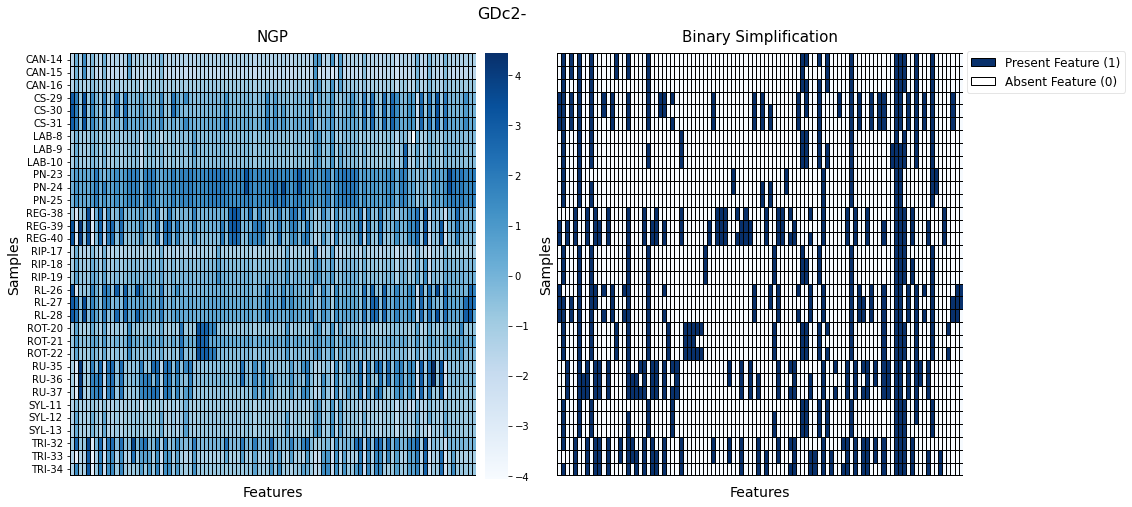

In [82]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(16,8))

cbar_ax = fig.add_axes([0.485, .13, .02, .74]) # For the colorbar

# For the BinSim legend
Blues = cm.get_cmap('Blues', 20)
Present_Feature = mpatches.Patch(color=Blues(range(20))[-1], label='Present Feature (1)')
Absent_Feature = mpatches.Patch(color='white', label='Absent Feature (0)')

# NGP Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['NGP'].iloc[:,50:150], annot=False, ax=axl, cmap = 'Blues', linewidths = 1, 
                 linecolor = 'black',  xticklabels = False, cbar_ax=cbar_ax)#, norm=LogNorm())#cbar = False,
bottom, top = axl.get_ylim()

axl.set_ylim(bottom + 0.5, top - 0.5)
axl.set_title('NGP', fontsize=15)
axl.set_xlabel('Features', fontsize=14)
axl.set_ylabel('Samples', fontsize=14)

# BinSim Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['BinSim'].iloc[:,50:150], annot=False, ax=axr, cmap = 'Blues', linewidths = 1, 
                 linecolor = 'black', cbar = False, xticklabels = False, yticklabels = False)
bottom, top = axr.get_ylim()
axr.set_ylim(bottom + 0.5, top - 0.5)
axr.set_title('Binary Simplification', fontsize=15)
axr.set_xlabel('Features', fontsize=14)
axr.set_ylabel('Samples', fontsize=14)
axr.legend(handles = [Present_Feature, Absent_Feature], bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0., 
           fontsize = 12, ncol=1, frameon=True, framealpha=0.5, facecolor='white')
# Black box around legend colours
for legend_handle in axr.get_legend().legendHandles:
    legend_handle.set_edgecolor('black')
    
fig.suptitle('GDc2-', fontsize = 16, y=0.95)
plt.show()
